Phys165 - Fall 2019 <br>
Lab 1 - Fitting SN1a magnitude vs redshift data for $\Omega_M$ and $\Omega_\Lambda$ <br>
Author: Evan Shipley <br>
Date: 09/26/2019

We will now extend our work from homework 3 to include magnitude vs redshift data to higher redshift. The data are in the file: 

'SN1A_data.csv'

In homework 3, the theoretical relation we used was:

$m(z) = M' + 5 \log_{10} d_L(z;\Omega_M,\Omega_\Lambda) \; \approx M' + 5 \log_{10}z \;\;\; for \;  z<<1$  <br>

However, for this lab, we must now use the full prediction for the luminosty distance $d_L$, which is a function of the cosmological parameters 
$\Omega_M,\Omega_\Lambda$.

You are being asked to use the scipy function "curve_fit" to estimate the best fit parameters for $\Omega_M,\Omega_\Lambda$ with the data you are given in the file.

The full function for $d_L$ is:

$d_L(z;\Omega_M,\Omega_\Lambda) = \frac{(1+z)}{\sqrt{|k|}} 
S(\sqrt{|k|}\int_0^z [(1+z')^2(1+\Omega_M z')
-z'(2+z')\Omega_\Lambda]^{-1/2} dz'  $

where,

$\begin{array}{lccr}
S(x) = sin(x) & k=1-\Omega_M-\Omega_\Lambda   & for &\Omega_M+\Omega_\Lambda > 1 \\
S(x) = sinh(x) & k=1-\Omega_M-\Omega_\Lambda & for & \Omega_M+\Omega_\Lambda < 1 \\
S(x) = x & k=1 & for & \Omega_M+\Omega_\Lambda = 1 
\end{array}$

Lab 1: write code below to <br>
1) read in the magnitude vs redshift data from 'SN1A_data.csv' <br>
2) write a user defined function for the theory of magnitude vs redshift that is also a function of the cosmological parameters $\Omega_M$ and $\Omega_\Lambda$ <br>
3) Plot the mag vs redshift data and best fit on top subplot and residuals vs redshift on bottom subplot clearly showing best fit parameters ($\Omega_M,\Omega_\Lambda$), $\chi_\nu^2$ and $\chi^2$ probability  <br>
4) write a user defined function for the theory of magnitude vs redshift that is also a function of the cosmological parameters $\Omega_M$ and $\Omega_\Lambda$, but, with $\Omega_M +\Omega_\Lambda$ constrained to 1.0 <br>
5) Plot the mag vs redshift data and best fit on top subplot and residuals vs redshift on bottom subplot, for the constrained case, clearly showing best fit parameters ($\Omega_M,\Omega_\Lambda$), $\chi_\nu^2$ and $\chi^2$ probability  <br>

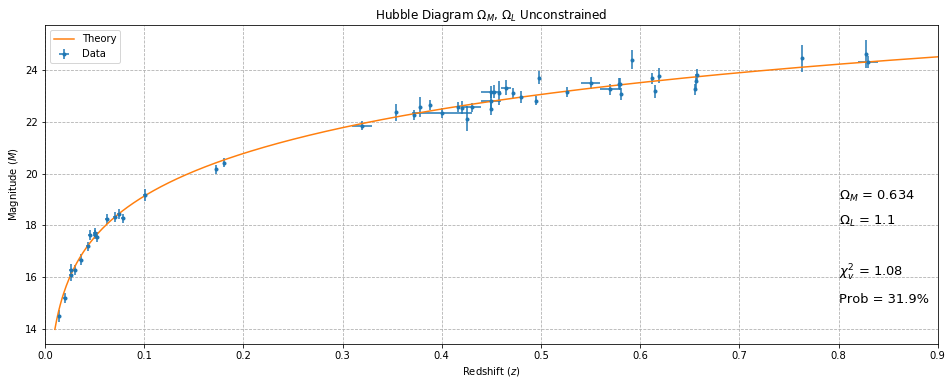

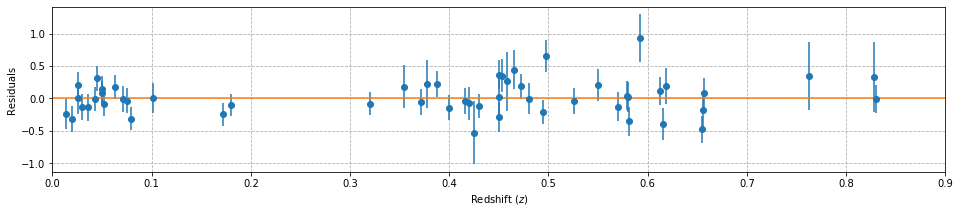

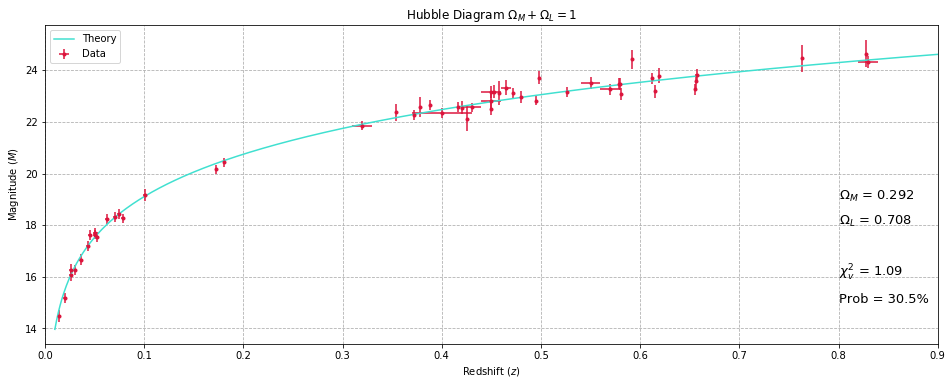

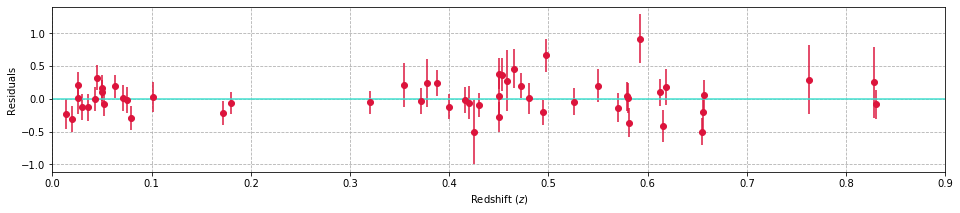

In [206]:
"""
Program to read in magnitude vs redshift data from file 
'SN1A_data.csv'
and fit for cosmological parameters Omega_Matter , Omega_Lambda
"""
#standard library modules
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# for numerical integration
from scipy.integrate import quad

#need this for chi**2 probability
import scipy.stats as st

#for curve fit
from scipy.optimize import curve_fit


"""
These provided user functions; I_z and D_l  together give 
the luminosity distance to be used in 
m(z) = M'+5*log10(D_l[z;Om_M,Om_L]) from the reference
astro-ph/9608192v2

The call to D_l returns the distance, D_l calls I_z

requires:
    import numpy as np
    from scipy.integrate import quad
    called above.
"""
def I_z(x,O_M,O_L):
    """
    Integrand from paper
    O_M = Omega_matter
    O_L = Omega_Lambda
    x = integration over z'
    """
    # Integral part of full function from astro-ph/9608192v2
    Integral = 1./np.sqrt((1.+x)**2*(1.+O_M*x)-x*(2.+x)*O_L)
    return Integral


def D_l(z,Om_M,Om_L):
    """
    calculates the luminosty distance 
    m(z) = M'+5*log10(D_l[z;Om_M,Om_L])
    as a function of redshift (z) given the
    cosmological parameters Om_m and Om_L
    inputs:
        z = array of redshifts
        Om_M = Omega Matter
        Om_L = Omega Lambda
    returns:
        D_l(z) = array of Luminosity distances corresonding to z 
    """
    # first do the integral
    zrange = z
    intgrl = np.zeros(np.size(zrange))
    for i in range(np.size(zrange)):
        intgrl[i],err = quad(I_z,0,zrange[i],args=(Om_M,Om_L))
    
    # full function from astro-ph/9608192v2
    
    if (Om_M + Om_L) < 0.999:
        K=np.sqrt(np.abs(1.-Om_M-Om_L))
        S = np.sinh(K*intgrl)
    elif (Om_M + Om_L) > 1.001:
        K=np.sqrt(np.abs(1.-Om_M-Om_L))
        S = np.sin(K*intgrl)
    else:
        K=1.
        S = K*intgrl
    
    D = (1.0 + z) * S / K
    
    return D



# your code here...

Z, Sig_z, Mag, Sig_M = np.loadtxt('SN1A_data.csv',delimiter=',',unpack=True)
def thry (Z,Om_M,Om_L):
    M=23.95
    return M+5.0*np.log10(D_l(Z,Om_M,Om_L))

def thry_constrained (Z,Om_M):
    M=23.95
    Om_L=1.0-Om_M
    return M+5.0*np.log10(D_l(Z,Om_M,Om_L))

def thry_constrained_returnOmL (Z,Om_L):
    M=23.95
    Om_M=1.0-Om_L
    return M+5.0*np.log10(D_l(Z,Om_M,Om_L))

p0=.4,.7
popt,pcov=curve_fit(thry,Z,Mag,p0,sigma=Sig_M,absolute_sigma=True)
OmM=popt[0]
OmL=popt[1]
#print(OmM)
#print(OmL)

p0=.3
popt,pcov=curve_fit(thry_constrained,Z,Mag,p0,sigma=Sig_M,absolute_sigma=True)
OmMfit=popt[0]
#print(OmMfit)

p0=.6
popt,pcov=curve_fit(thry_constrained_returnOmL,Z,Mag,p0,sigma=Sig_M,absolute_sigma=True)
OmLfit=popt[0]
#print(OmLfit)

i=np.argsort(Z)

def chi_squared(Theory,Data,sigma):
    
    if np.size(thry(Z[i],OmM,OmL))==np.size(Mag) and np.size(Mag)==np.size(Sig_z):
        chi2=np.sum((thry(Z[i],OmM,OmL)-Mag[i])**2/Sig_M[i]**2)
        return chi2
    else:
        print('error - arrays of unequal size')
        return -1.
    
def chi_squared_constrained(Theory,Data,sigma):
    
    if np.size(thry_constrained(Z[i],OmMfit))==np.size(Mag) and np.size(Mag)==np.size(Sig_z):
        chi2=np.sum((thry_constrained(Z[i],OmMfit)-Mag[i])**2/Sig_M[i]**2)
        return chi2
    else:
        print('error - arrays of unequal size')
        return -1.
    
dof=np.size(Z)-1    
chi2=chi_squared(thry(Z[i],OmM,OmL),Mag[i],Sig_M[i])
chi_2=chi2/dof

chi2_constrained=chi_squared_constrained(thry_constrained(Z[i],OmMfit),Mag[i],Sig_M[i])
chi_2_constrained=chi2_constrained/dof
#print(chi2)
#print(chi2_constrained)
prob=st.chi2.sf(chi2,dof)
prob_constrained=st.chi2.sf(chi2_constrained,dof)

f=plt.figure(figsize=(16,10))
f=plt.subplot2grid((5,1),(0,0),rowspan=3)
f=plt.errorbar(Z,Mag,xerr=Sig_z,yerr=Sig_M,fmt='.',label='Data');
Z_plot=np.linspace(0.01,.9,1000)
plt.plot(Z_plot,thry(Z_plot,OmM,OmL),label='Theory')
plt.xlim(0,0.9)
plt.legend()
plt.grid(True,linestyle='--')
plt.title('Hubble Diagram $\Omega_{M}$, $\Omega_{L}$ Unconstrained')
plt.xlabel('Redshift ($z$)')
plt.ylabel('Magnitude ($M$)')
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,3))
plt.text(.8,16,r'$\chi_v^2$ = {:.2f}'.format(chi_2),size=13)
plt.text(.8,15,r'Prob = {:.1%}'.format(prob),size=13)
plt.text(.8,19,r'$\Omega_M$ = {:.3g}'.format(OmM),size=13)
plt.text(.8,18,r'$\Omega_L$ = {:.3g}'.format(OmL),size=13)

res1plot=plt.figure(figsize=(16,8))
res1plot=plt.subplot2grid((5,1),(0,0),rowspan=2)
res=Mag-thry(Z,OmM,OmL)
plt.errorbar(Z,res,yerr=Sig_M,fmt='o')
plt.xlim(0,0.9)   #setting limits for x-axis
plt.plot([0,0.9],[0,0])   #plot flat line at residual=0 from x=0->.11
plt.xlabel('Redshift ($z$)')
plt.ylabel('Residuals')
plt.grid(True,linestyle='--')
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,3))

h=plt.figure(figsize=(16,10))
h=plt.subplot2grid((5,1),(0,0),rowspan=3)
plt.errorbar(Z,Mag,xerr=Sig_z,yerr=Sig_M,fmt='.',label='Data',color='crimson');
Z_plot=np.linspace(0.01,.9,1000)
plt.plot(Z_plot,thry_constrained(Z_plot,OmMfit),label='Theory',color='turquoise')
plt.xlim(0,0.9)
plt.legend()
plt.grid(True,linestyle='--')
plt.title('Hubble Diagram $\Omega_{M}+\Omega_{L}=1$')
plt.xlabel('Redshift ($z$)')
plt.ylabel('Magnitude ($M$)')
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,3))
plt.text(.8,16,r'$\chi_v^2$ = {:.2f}'.format(chi_2_constrained),size=13)
plt.text(.8,15,r'Prob = {:.1%}'.format(prob_constrained),size=13)
plt.text(.8,19,r'$\Omega_M$ = {:.3g}'.format(OmMfit),size=13)
plt.text(.8,18,r'$\Omega_L$ = {:.3g}'.format(OmLfit),size=13)

res2plot=plt.figure(figsize=(16,8))
res2plot=plt.subplot2grid((5,1),(0,0),rowspan=2)
res2=Mag-thry_constrained(Z,OmMfit)
plt.errorbar(Z,res2,yerr=Sig_M,fmt='o',color='crimson')
plt.xlim(0,0.9)   #setting limits for x-axis
plt.plot([0,0.9],[0,0],color='turquoise')   #plot flat line at residual=0 from x=0->.11
plt.xlabel('Redshift ($z$)')
plt.ylabel('Residuals')
plt.grid(True,linestyle='--')
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,3))



#plt.figure(figsize=(10,8))                  #This method of plotting the errorbars using sorted data
#plt.subplot2grid((5,1),(0,0),rowspan=3)     #gave slightly different errorbars so I stayed with 
#plt.errorbar(Z[i],Mag[i],xerr=Sig_z[i],yerr=Sig_M[i],fmt='.',label='Data') #plotting before sorting
#plt.plot(Z_plot,thry(Z_plot,OmM,OmL),label='Theory');

#for some reason the scilimits on the y-axis residuals did not work this time so my Theory/data plots' x axes
#and their residuals' x axes are not perfectly aligned like they were in HW 3